In [1]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model, preprocessing
import statsmodels.api as sm
from IPython.display import display
import warnings
import seaborn as sns
sns.set_style('whitegrid')
import grab_data as grab_data

# Helper Functions

In [2]:
default_fig_width = 15
target_var = 'surf_avg'
def plot_datetime_series(series, title = '', xlabel='Time', ylabel='Average Wave Height in m', label=['-', '-', '-', '-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        if type(s.index) is not pd.tseries.index.DatetimeIndex:
            dates = matplotlib.dates.date2num([dateutil.parser.parse(dt) for dt in s.index])
        else:
            dates = s.index
        plt.plot_date(
            dates,
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()

def plot_scatter_correlation(df, target, standardize=True):
    df = df.copy()
    if standardize: df = normalize(df)
    ncols = 3
    nrows = math.ceil(len(df.columns)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=True, figsize=(default_fig_width,4*nrows))
    fig.subplots_adjust(hspace=.3)
    for i,variable in enumerate(df.columns):
        row = math.floor(i / nrows)
        col = i % 3
        if nrows > 1:
            axis = axes[row,col]
        else:
            axis = axes[col]
        correlation = df[variable].corr(target)
        title = "corr = {:.5f}".format(correlation)
        sns.regplot(df[variable], target, ax=axis)
        axis.set_title(title)
    unused_axes = ncols * nrows - len(df.columns) 
    for i in range(1, unused_axes+1):
        if nrows > 1:
            axis = axes[-1,-i]
        else:
            axis = axes[-i]
        fig.delaxes(axis)

def normalize(df_in):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return df_in.apply(preprocessing.scale)

def drop_unused_target_variables(df_in):
    df_out = df_in.copy()
    if target_var not in df_out.columns:
        df_out[target_var] = calculate_target_variable(df_out)
    return df_out[['dew_point','pressure', 'screen_relative_humidity','temperature', 'wave_height', 'wave_period', 'wind_speed', target_var]]

# 3. Preliminary Analysis
## 3.1 Variables

In [3]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file, index_col=0) for file in csv_files])
df_imported.index = pd.DatetimeIndex(df_imported.sort_index().index)
grouped = df_imported.groupby(level=0)
df_imported = grouped.last()
df_imported.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2967 entries, 2016-05-17 20:00:00 to 2016-10-09 19:00:00
Data columns (total 25 columns):
$                           2958 non-null float64
dateStamp                   500 non-null object
dew_point                   2958 non-null float64
modelCode                   500 non-null object
modelRun                    500 non-null float64
periodSchedule              500 non-null float64
pressure                    2958 non-null float64
screen_relative_humidity    2958 non-null float64
sea_temperature             2958 non-null float64
surf_max                    500 non-null float64
surf_min                    500 non-null float64
swell_direction1            500 non-null float64
swell_direction2            500 non-null float64
swell_direction3            500 non-null float64
swell_height1               500 non-null float64
swell_height2               500 non-null float64
swell_height3               500 non-null float64
swell_period1        

## 3.2 Gauss Markov Assumptions
### 3.2.2 No Perfect Collinearity

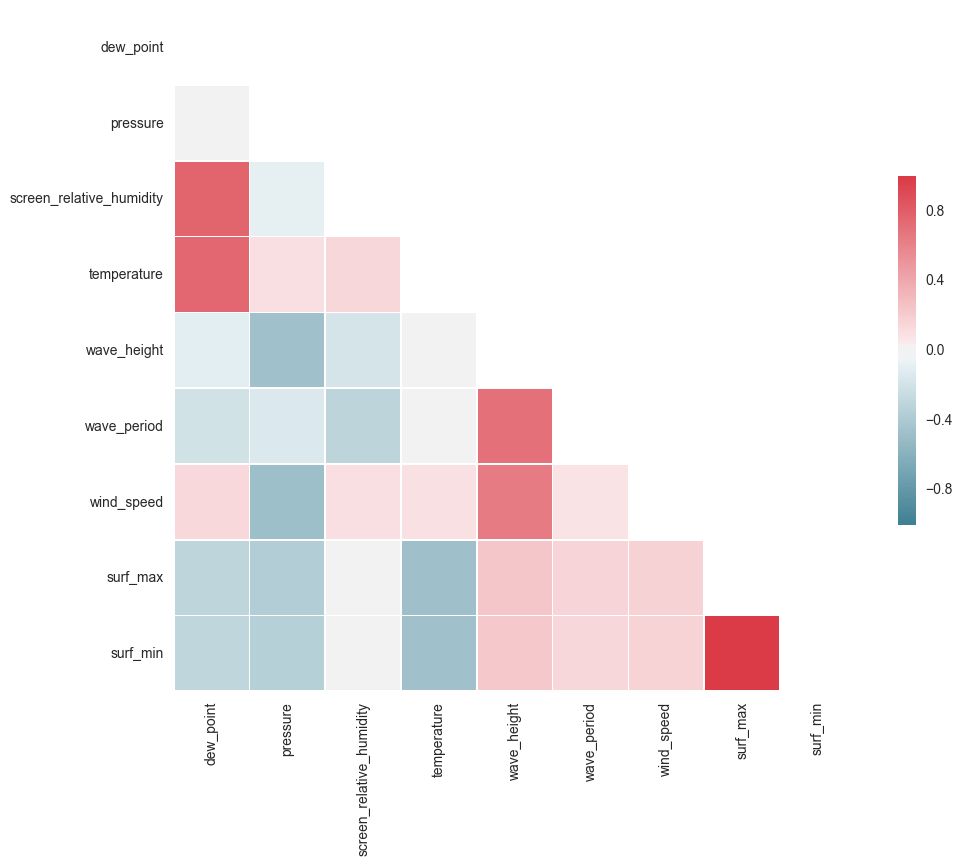

In [4]:
df_retained = df_imported[['dew_point','pressure', 'screen_relative_humidity','temperature', 'wave_height', 'wave_period', 'wind_speed', 'surf_max', 'surf_min']]
with sns.axes_style("white"):
    mask = np.zeros_like(df_retained.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df_retained.corr(), mask=mask, cmap=cmap, vmax=1,
                square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [5]:
fig, ax = plt.subplots(2,2, figsize=(default_fig_width,4*2), sharex=False, sharey=False)
sns.regplot(df_retained['temperature'],df_retained['dew_point'], ax=ax[0,0])
sns.regplot(df_retained['screen_relative_humidity'],df_retained['dew_point'], ax=ax[0,1])
sns.regplot(df_retained['surf_max'],df_retained['surf_min'], ax=ax[1,0])
sns.regplot(df_retained['wind_speed'], df_retained['wave_height'], ax=ax[1,1])

# 4. Transformation and Modelling
## 4.1 Target Variable
Calculate the average and convert feet to meters.

available target values: 500


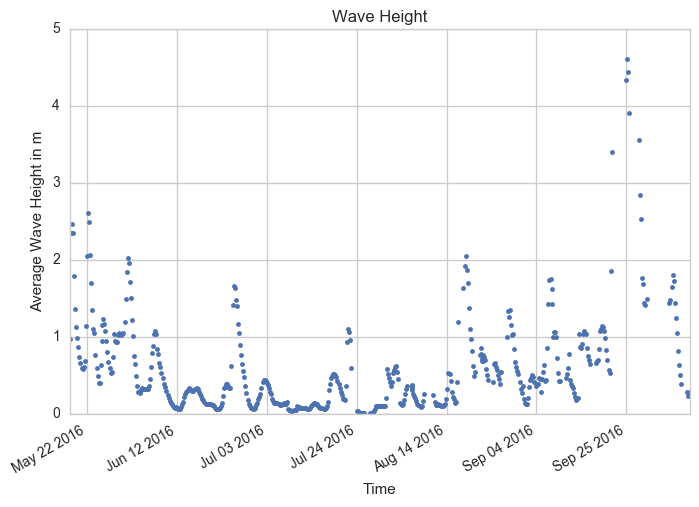

In [6]:
target_var = 'surf_avg'
def calculate_target_variable(df_in):
    return pd.Series( ((df_in['surf_max'] + df_in['surf_min']) / 2)*0.3048, name=target_var )
s_target = calculate_target_variable(df_imported)
print('available target values:', s_target.count())
plot_datetime_series(s_target, 'Wave Height', 'Time', 'Average Wave Height in m', '.')

## 4.2 Interpolation
Wind direction is omitted since it is non-numerical.

target values after interpolation: 3475


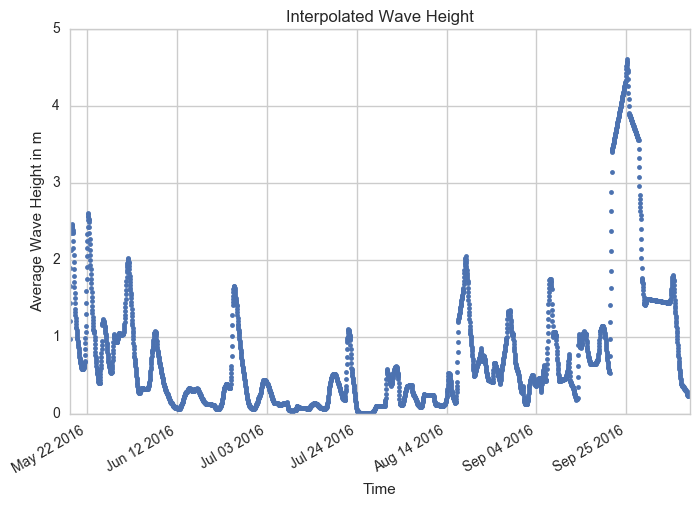

In [7]:
# Fill few missing values in explanatory data
def interpolate_missing_values(df_in):
    return df_in.resample('H').interpolate().dropna()
df_interpolated = pd.concat(
    [
        df_imported[['wave_height', 'wind_speed', 'wave_period', 'pressure', 'dew_point', 'screen_relative_humidity','temperature' ]],
        s_target
    ], axis=1)
df_interpolated = interpolate_missing_values(df_interpolated)

s_target = df_interpolated[target_var]
print('target values after interpolation:', s_target.count())  
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', '.')

## 4.3 Determination of Lag
In order to find out the lag between target variable and each of the explanatory variables, a cross correlation for all lags between 0h and 24h is computed. Afterwards, the correlation of the best fitting lags is looked at more closely.

In [8]:
def cross_correlation(s1, s2, minlag=0, maxlag=72):
    if((s1.index != s2.index).any()):
        print('Indexes differ!')
        return
    s_result = pd.Series(index=range(minlag, maxlag))
    for lag in range(minlag, maxlag+1):
        s_result[lag] = s1.shift(lag).corr(s2)
    return s_result

def abs_max_at(s):
    max_index = s.index[0]
    max_value = s.values[0]
    for i, v in s.iteritems():
        if abs(v) > abs(max_value):
            max_index = i
            max_value = v
    return max_index

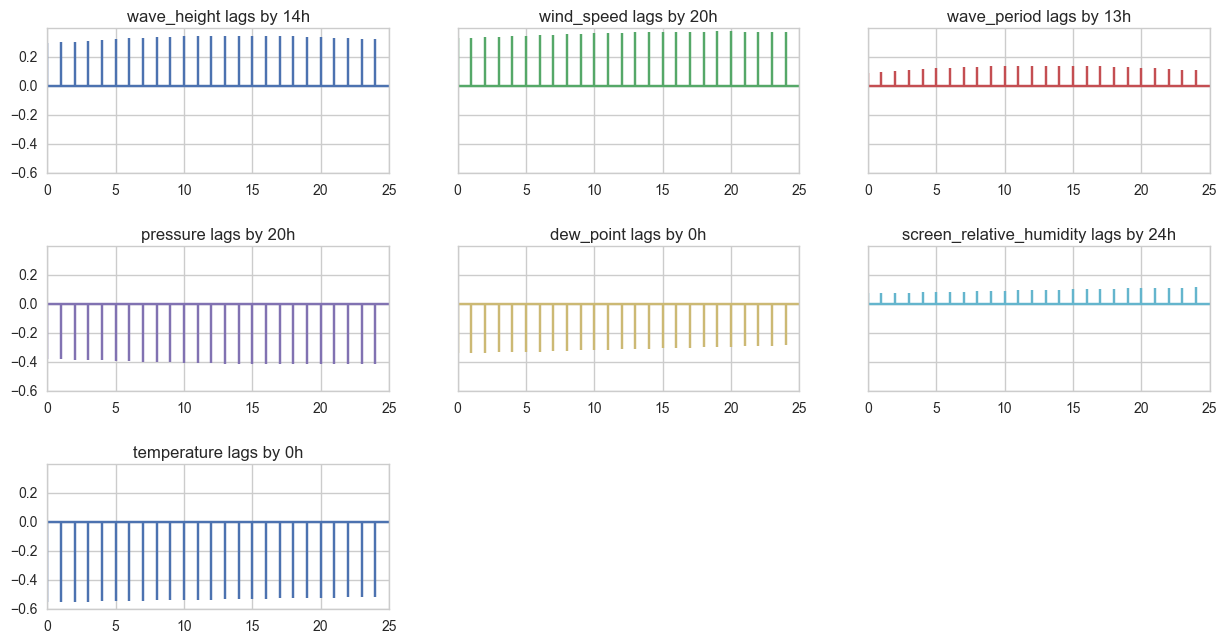

In [9]:
df_explanatory = df_interpolated.drop('surf_avg', axis=1)

# for each explanatory variable, plot lags and determine optimum
optimal_lags = pd.Series(index=df_explanatory.columns)
nrows = math.ceil(len(df_explanatory.columns) / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=3, sharey=True, sharex=False, figsize=(default_fig_width,nrows*2.5))
fig.subplots_adjust(hspace=.5)
for i,var in enumerate(df_explanatory.columns):
    # style: select column, row and color for chart
    row = math.floor(i / 3)
    col = i % 3
    if nrows == 1: axis = axes[col]
    else: axis = axes[row,col]
    if i < len(sns.color_palette()): color = sns.color_palette()[i]
    else: color = sns.color_palette()[i-len(sns.color_palette())]
    
    # calculate cross correlation and find optimum, save it for later use
    xcorr = cross_correlation(df_interpolated[var], df_interpolated[target_var], maxlag=24)
    optimal_lags[var] = abs_max_at(xcorr)
    
    # plot all cross correlations
    axis.vlines(x=xcorr.index, ymin=0, ymax=xcorr.values, color=color)
    axis.axhline(color=color)
    axis.set_title(var + ' lags by ' + "{0:g}".format(optimal_lags[var]) + 'h')

# delete unused charts
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

complete training rows left after lagging: 3451 (lost: 24 )


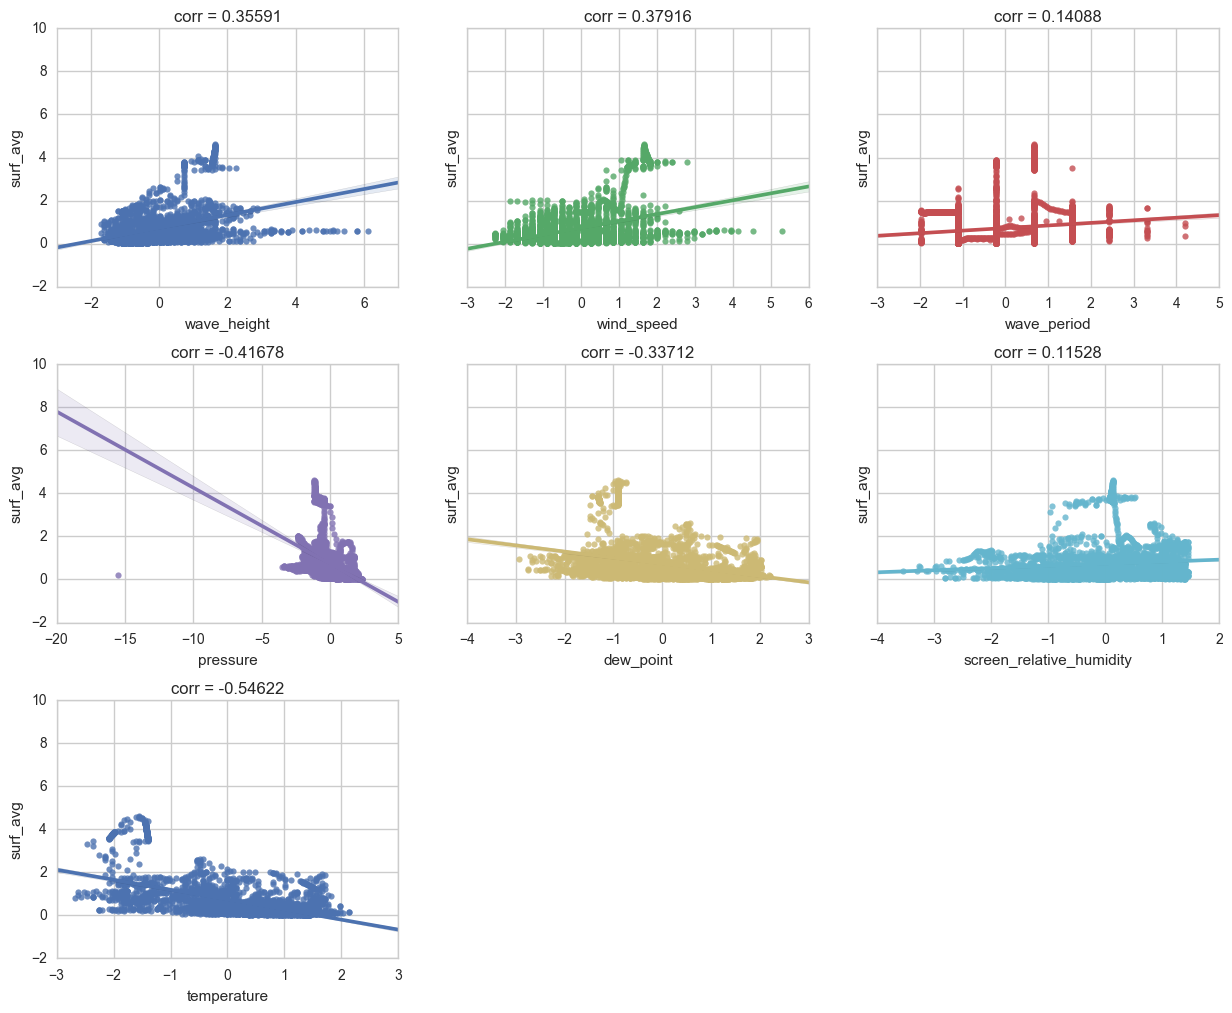

In [10]:
def lag(df_in, lags=optimal_lags):
    df_lagged = pd.DataFrame()
    for var, lag in lags.iteritems():
        if var in df_in.columns:
            df_lagged = pd.concat(
                [df_lagged, df_in[var].shift(lag, freq='H', axis=0)],
                axis=1
            )
    for var in df_in.columns:
        if var not in lags.index:
            df_lagged[var] = df_in[var]
    return df_lagged.dropna()

df_lagged = pd.concat([
        lag(df_explanatory, optimal_lags),
        s_target], 
        axis=1
).dropna()
print('complete training rows left after lagging:', len(df_lagged), '(lost:', len(df_interpolated)-len(df_lagged), ')')

# update target variable and lose data not described by lagged independent variables anymore
s_target_lagged = df_lagged[target_var]

plot_scatter_correlation(df_lagged.drop(target_var, axis=1), df_lagged[target_var])

## 4.4 Transforming Wind Direction

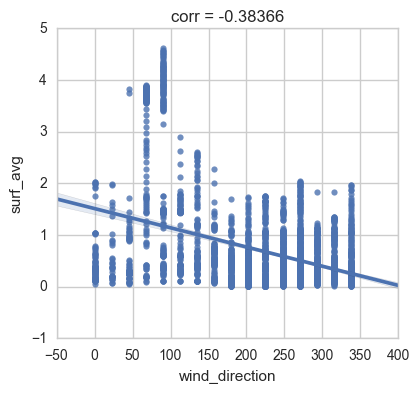

In [11]:
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
def compass_to_degrees(s_in):
    s_out = pd.Series(index=s_in.index, name=s_in.name)
    for i,dir in enumerate(s_in.dropna()):
        s_out[i] = (360 / len(compass_directions)) * compass_directions.index(dir)
    return s_out
s_wind_direction = compass_to_degrees(df_imported['wind_direction'])

# interpolation is dangerous! 1° to 360° will be interpolated with 180°!
# instead, forward fill to be sure
def fillna_wind_direction(s_in):
    return s_in.resample('H').fillna(method='ffill')
s_wind_direction = fillna_wind_direction(s_wind_direction)

def lag_wind_direction(s_in):
    # tie lag of wind_direction to wind_speed
    s_out = s_in.shift(optimal_lags['wind_speed'], freq='H', axis=0)
    # crop to fit on rest of data
    return s_out[df_lagged.index[0]:df_lagged.index[-1]]

s_wind_direction = lag_wind_direction(s_wind_direction)

plot_scatter_correlation(pd.DataFrame(s_wind_direction), s_target_lagged, standardize=False)

### 4.4.1 Sine Cosine Transformation
This example illustrates how 360° and 0° have a distance of 0 after sine cosine transformation.

In [12]:
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    df_sin = df_radians.apply(lambda series: series.map(math.sin))
    df_cos = df_radians.apply(lambda series: series.map(math.cos))
    df_sin.columns = [col + '-Sin' for col in df_sin.columns]
    df_cos.columns = [col + '-Cos' for col in df_cos.columns]
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            df_sin,
            df_cos
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[361, 1]})

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))

degrees
0      361
1        1

degrees-Sin  degrees-Cos
0     0.017452     0.999848
1     0.017452     0.999848

In the following, the sine cosine transformation is applied to actual data.

wind_direction
2016-05-17 20:00:00             NE
2016-05-17 21:00:00             NE
2016-05-17 22:00:00            ENE
2016-05-17 23:00:00             NE
2016-05-18 00:00:00             NE

becomes


wind_direction
2016-05-19 01:00:00            67.5
2016-05-19 02:00:00            45.0
2016-05-19 03:00:00            22.5
2016-05-19 04:00:00            22.5
2016-05-19 05:00:00            22.5

becomes


wind_direction-Sin  wind_direction-Cos
2016-05-19 01:00:00            0.923880            0.382683
2016-05-19 02:00:00            0.707107            0.707107
2016-05-19 03:00:00            0.382683            0.923880
2016-05-19 04:00:00            0.382683            0.923880
2016-05-19 05:00:00            0.382683            0.923880

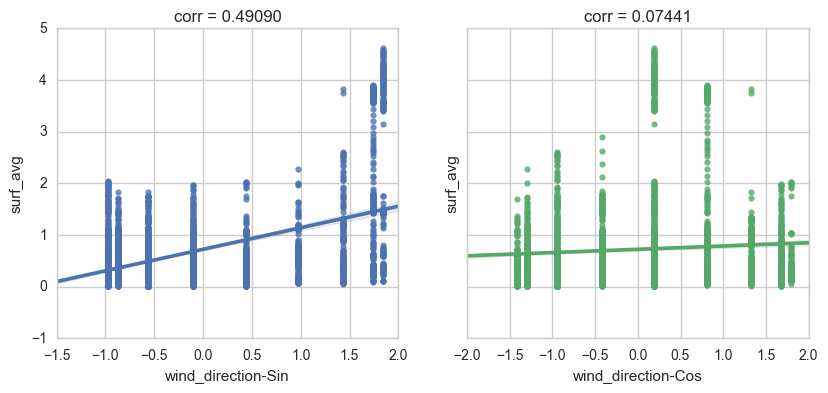

In [13]:
def transform_wind_direction_sin_cos(s_in):
    df_out = pd.DataFrame(s_in)
    df_out = degrees_to_sin_cos(df_out, 'wind_direction')
    return df_out
display(df_imported[['wind_direction']].head())
print('becomes')
display(pd.DataFrame(s_wind_direction).head())
print('becomes')
df_wind_direction_sin_cos = transform_wind_direction_sin_cos(s_wind_direction)
display(df_wind_direction_sin_cos.head())
plot_scatter_correlation(
    normalize(df_wind_direction_sin_cos), 
    s_target_lagged
)

### 4.4.2 Degree Deviation Transformation
The previous approach gives a numerical view on wind direction where 360 and 0 degrees are equal. However, this doesn't result in a linear correlation, which is expected to exist for wind direction.

Highest absolute correlation is 0.511 at 76 degrees.
The inverse is at 256 degrees.


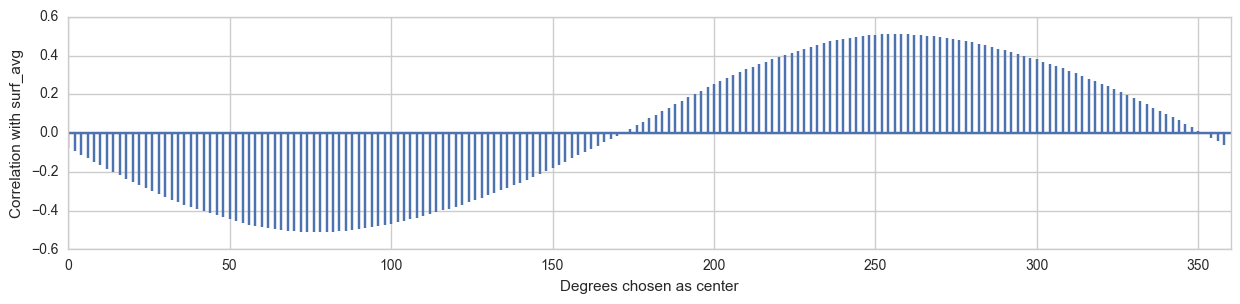

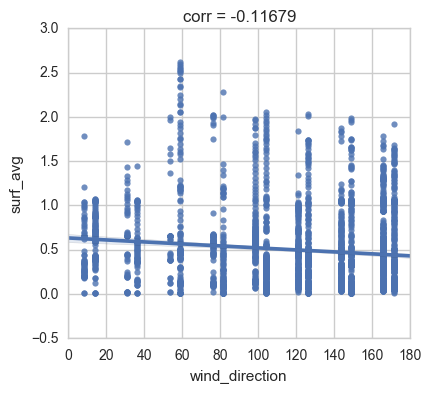

In [14]:
def compute_degree_diff(degrees_base, i):
    diff = abs(degrees_base - i) % 360
    def under_180(alpha):
        if(alpha > 180):
            return 360 - alpha
        else:
            return alpha
    return diff.apply(under_180)

degree_corr = pd.Series(index=range(0,360,2))
for i in degree_corr.index:
    degree_corr[i] = compute_degree_diff(s_wind_direction, i).corr(s_target)

def plot_degree_corr(degree_corr):
    fig, ax = plt.subplots(figsize=(math.floor(default_fig_width),3))
    ax.vlines(
        x=degree_corr.index, 
        ymin=0,
        ymax=degree_corr.values,
        color=sns.color_palette()[0]
    )
    ax.axhline(color=sns.color_palette()[0])
    ax.set_xlabel('Degrees chosen as center')
    ax.set_ylabel('Correlation with surf_avg')
    ax.set_xbound(None, 360)

plot_degree_corr(degree_corr)

max_corr = degree_corr.max()
max_corr_at = degree_corr[abs(degree_corr) == max_corr].index[0]
print('Highest absolute correlation is {:.3f}'.format(max_corr) ,'at', max_corr_at, 'degrees.')
print('The inverse is at', 180+max_corr_at, 'degrees.')

def transform_wind_direction(df_in, max_corr_at=max_corr_at):
    df_out = df_in.copy()
    df_out['wind_direction'] = compass_to_degrees(df_out['wind_direction'])
    df_out['wind_direction'] = fillna_wind_direction(df_out['wind_direction'])
    df_out['wind_direction'] = lag_wind_direction(df_out['wind_direction'])
    df_out['wind_direction'] = compute_degree_diff(df_out['wind_direction'], max_corr_at)
    return df_out.dropna()

df_transformed = pd.concat([df_lagged, df_imported['wind_direction']], axis=1)
df_transformed = transform_wind_direction(df_transformed)


plot_scatter_correlation(df_transformed[['wind_direction']], df_transformed[target_var], standardize=False)

### 4.4.3 Wind Coefficient
Unite wind direction and wind speed into a single value.

Highest absolute correlation is 0.182 at 254 degrees.


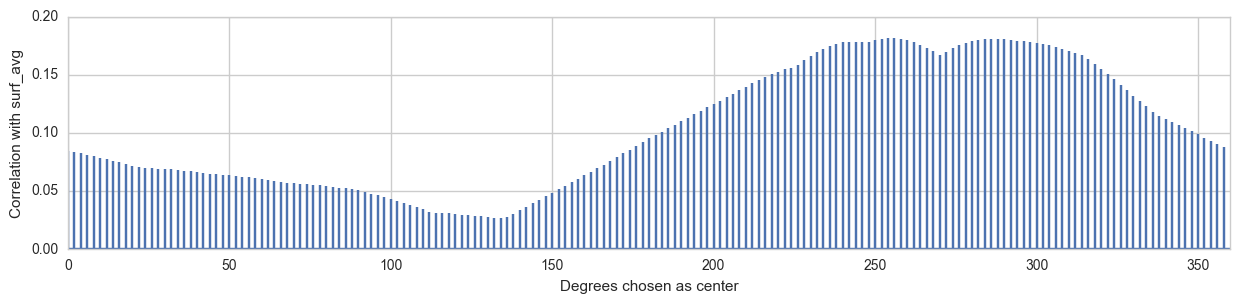

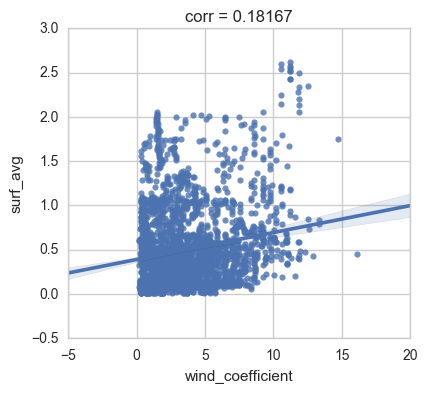

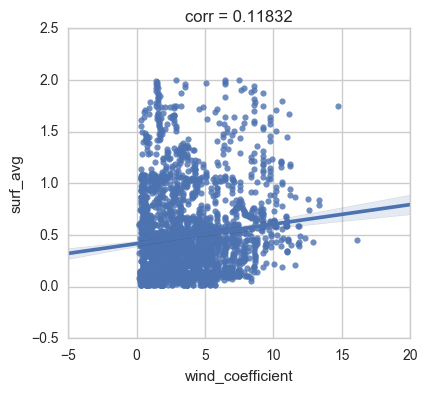

In [15]:
def get_wind_coefficient(s_dir, s_speed):
    return (s_dir / 180) * s_speed

coefficient_degree_corr = pd.Series(index=range(0,360,2))
for i in coefficient_degree_corr.index:
    s_dir = compute_degree_diff(s_wind_direction, i)
    coeff = get_wind_coefficient(s_dir, df_transformed['wind_speed'])
    coefficient_degree_corr[i] = coeff.corr(s_target)
plot_degree_corr(coefficient_degree_corr)

max_corr = coefficient_degree_corr.max()
max_corr_at = coefficient_degree_corr[abs(coefficient_degree_corr) == max_corr].index[0]
print('Highest absolute correlation is {:.3f}'.format(max_corr) ,'at', max_corr_at, 'degrees.')

def add_wind_coefficient(df_in):
    df_out = df_in.copy()
    df_out['wind_coefficient'] = get_wind_coefficient(
        compute_degree_diff(s_wind_direction, max_corr_at),
        df_in['wind_speed']
    )
    return df_out

df_transformed = add_wind_coefficient(df_transformed)

plot_scatter_correlation(df_transformed[['wind_coefficient']], df_transformed[target_var], standardize=False)

# hide outliers
mask_outliers = [(h <= 2) for h in df_transformed[target_var]]
plot_scatter_correlation(df_transformed[['wind_coefficient']][mask_outliers], df_transformed[target_var][mask_outliers], standardize=False)

## 4.5 Moving Averages
Roll back the lag slightly and apply a rolling mean to smooth out predictions.

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,ignore_na=False,span=6,min_periods=0).mean()


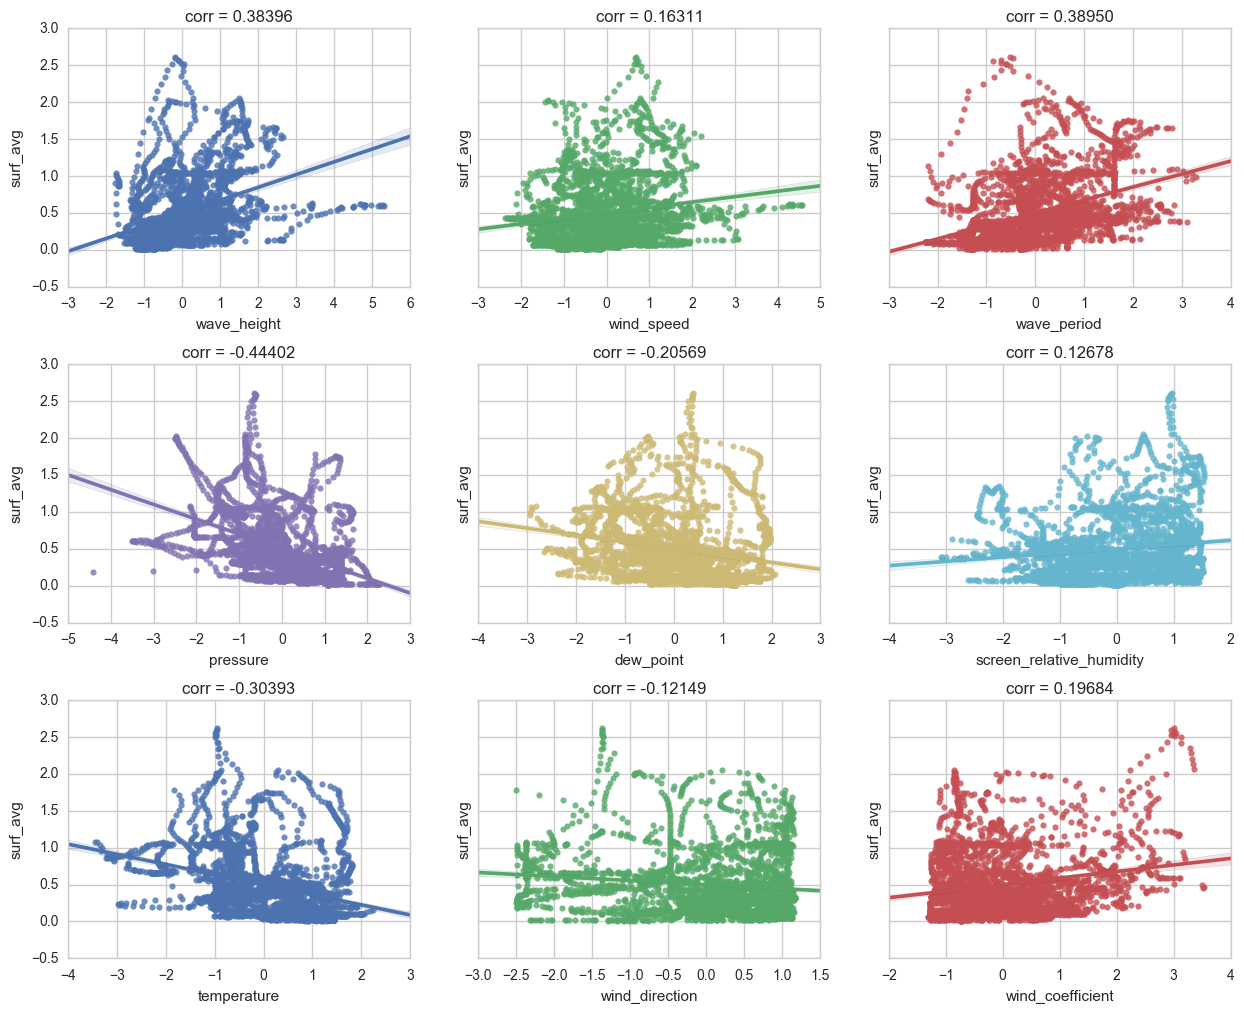

In [16]:
def moving_averages(df_in, window=12, unshift=0, method='ewma'):
    df_out = df_in.copy()
    for column in df_out.columns:
        df_out[column] = df_out[column].shift(-unshift, freq='H', axis=0)
        if method is 'ma':
            df_out[column] = pd.rolling_mean(df_out[column], window, min_periods=0)
        if method is 'ewma':
            df_out[column] = pd.ewma(df_out[column], span=window)
    return df_out

df_ma = moving_averages(df_transformed.copy().drop(target_var, axis=1), 6, 0)
df_ma[target_var] = s_target
plot_scatter_correlation(df_ma.drop(target_var,axis=1), df_ma[target_var])

## 4.6 Validation

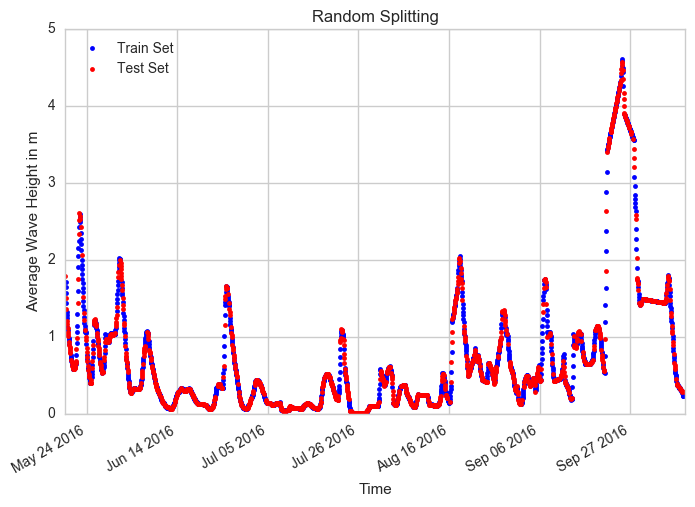

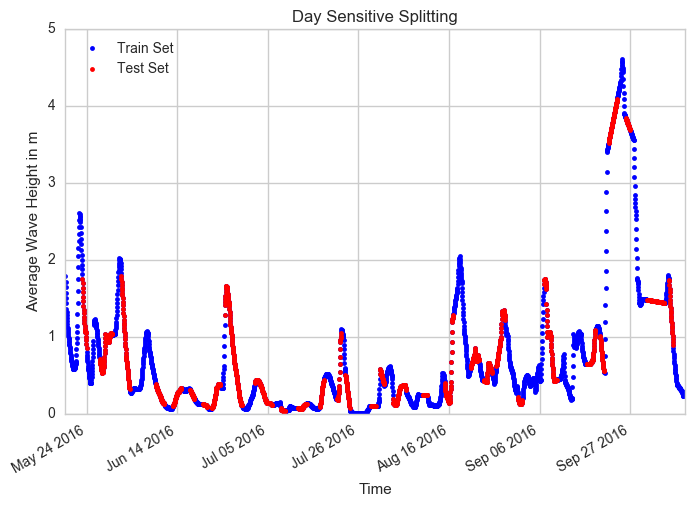

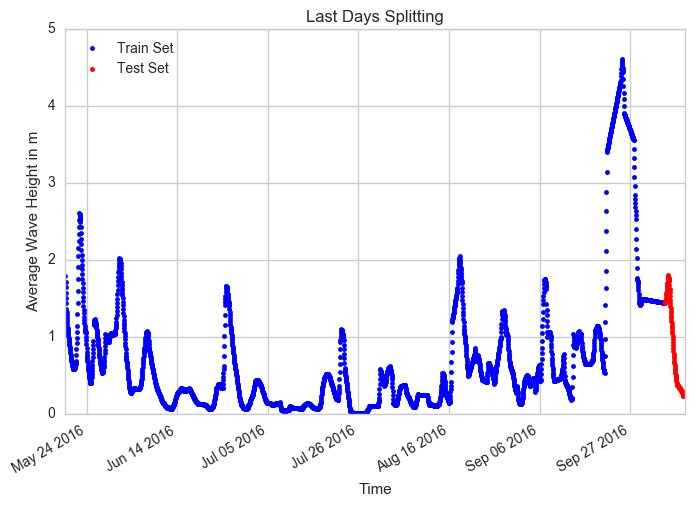

In [17]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

def split_dataset_day_sensitive(df_in, percent_test):
    days = pd.Series(df_in.index).map(pd.Timestamp.date).unique()
    total_size = len(days)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ str(days[randint]) for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.concat([df_train[l] for l in record_labels], axis=0)
    for l in record_labels:
        df_train.drop(df_train[l].index)
    return df_train, df_test

def split_dataset_last_days(df_in, days_count):
    days = pd.Series(df_in.index).map(pd.Timestamp.date).unique()
    record_labels = [ str(days[i]) for i in range(-days_count-1, 0) ]
    df_train = df_in.copy()
    df_test = pd.concat([df_train[l] for l in record_labels], axis=0)
    for l in record_labels:
        df_train = df_train.drop(df_train[l].index)
    return df_train, df_test

train_set, test_set = split_dataset(df_lagged, 0.4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'], title='Random Splitting')

train_set, test_set = split_dataset_day_sensitive(df_lagged, 0.4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'], title='Day Sensitive Splitting')

train_set, test_set = split_dataset_last_days(df_lagged, 4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'], title='Last Days Splitting')


## 4.7 Fitting the Model

In [18]:
def preprocess(df_in, drop_unused=False, ma=False):
    explanatory_import_columns = ['wave_height', 'wave_period', 'wind_speed', 'wind_direction', 'dew_point','pressure', 'screen_relative_humidity','temperature']
    df_out = df_in.copy()[explanatory_import_columns]
    if(drop_unused):
        df_out = df_out[['wave_height', 'wind_speed', 'wind_direction']]
    preprocessing_functions = [
        'lag',
        'transform_wind_direction',
        'interpolate_missing_values',
        'add_wind_coefficient',
        'normalize'
    ]
    if ma:
        preprocessing_functions.append('moving_averages')
    for fn in preprocessing_functions:
        df_out = globals()[fn](df_out)
    if(drop_unused):
        df_out = df_out[['wave_height', 'wind_coefficient']]
    return df_out.dropna()

def align_data(df_in, s_in):
    merged = pd.concat([df_in, s_in], axis=1).dropna()
    df_out = merged[df_in.columns]
    s_out = merged[s_in.name]
    return df_out, s_out
def train_linear_model(train_set, target=None):
    train_set = train_set.copy()
    if target is None:
        target = train_set[target_var]
        train_set = train_set.drop(target_var, axis=1)
    else:
        # make sure data is aligned
        train_set, target = align_data(train_set, target)
    model = linear_model.LinearRegression()
    model.fit(
        train_set.as_matrix(), 
        target.as_matrix()
    )
    ols = sm.OLS(target, train_set).fit()
    display(ols.summary())
    return model

def predict(test_set, model):
    test_set = test_set.copy()
    if target_var in test_set.columns:
        test_set = test_set.drop(target_var, axis=1)
    return pd.Series(
        model.predict(test_set.as_matrix()), 
        name='Prediction', 
        index=test_set.index
    )

### 4.7.1 Entire Feature Set

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,ignore_na=False,span=12,min_periods=0).mean()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     228.8
Date:                Mon, 10 Oct 2016   Prob (F-statistic):               0.00
Time:                        15:19:35   Log-Likelihood:                -4146.2
No. Observations:                3248   AIC:                             8310.
Df Residuals:                    3239   BIC:                             8365.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
wave_height                  0.5958      0.053     11.202      0.000         0.491     0.700
wind_speed                  -0.4550      0.042    -10.848      0.000        -0.537    -0.373
wave_period                 -0.1438      0.037     -3.932      0.000        -0.216    -0.072
pressure                    -0.0655      0.022     -2.912      0.004        -0.110    -0.021
dew_point                    0.2191      0.029      7.559      0.000         0.162     0.276
screen_relative_humidity     0.0591      0.020      2.944      0.003         0.020     0.098
temperature                 -0.3045      0.029    -10.649      0.000        -0.361    -0.248
wind_direction               0.2639      0.033      8.026      0.000         0.199     0.328
wind_coefficient             0.7833      0.032     24.107      0.000         0.720     0.847
==============================================================================
Omnibus:                      357.846   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              573.645
Skew:                           0.782   Prob(JB):                    2.72e-125
Kurtosis:                       4.340   Cond. No.                         7.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

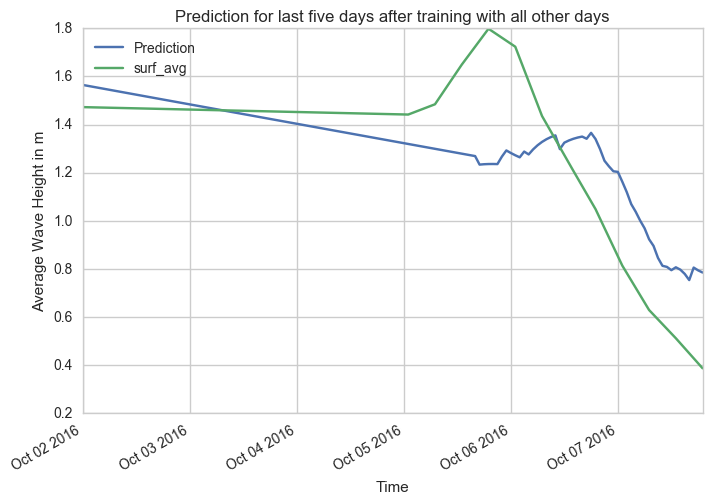

In [19]:
df_train = pd.concat(
    [
        preprocess(df_imported, ma=True, drop_unused=False),
        s_target
    ],
    axis=1
).dropna()

train_set, test_set = split_dataset_last_days(df_train, 5)
model = train_linear_model(train_set)
plot_datetime_series(
    [
        predict(test_set, model),
        test_set[target_var]
    ],
    title= 'Prediction for last five days after training with all other days'
)

### 4.7.2 No Moving Averages

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     190.8
Date:                Mon, 10 Oct 2016   Prob (F-statistic):          2.68e-291
Time:                        15:19:51   Log-Likelihood:                -4254.6
No. Observations:                3248   AIC:                             8527.
Df Residuals:                    3239   BIC:                             8582.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
wave_height                  0.3873      0.038     10.315      0.000         0.314     0.461
wind_speed                  -0.2452      0.030     -8.300      0.000        -0.303    -0.187
wave_period                 -0.0547      0.027     -2.050      0.040        -0.107    -0.002
pressure                    -0.0721      0.020     -3.555      0.000        -0.112    -0.032
dew_point                    0.1951      0.026      7.634      0.000         0.145     0.245
screen_relative_humidity     0.0423      0.018      2.397      0.017         0.008     0.077
temperature                 -0.3275      0.026    -12.425      0.000        -0.379    -0.276
wind_direction               0.0841      0.027      3.084      0.002         0.031     0.138
wind_coefficient             0.5487      0.027     20.579      0.000         0.496     0.601
==============================================================================
Omnibus:                      406.050   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.677
Skew:                           0.823   Prob(JB):                    1.18e-157
Kurtosis:                       4.622   Cond. No.                         5.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

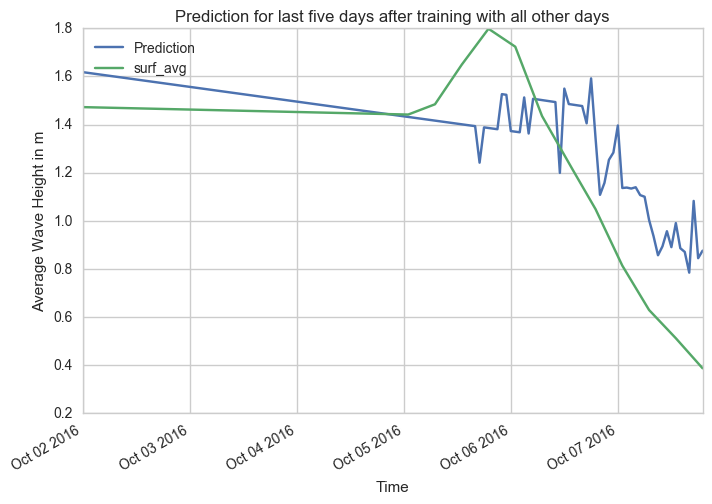

In [20]:
df_train = pd.concat(
    [
        preprocess(df_imported, ma=False, drop_unused=False),
        s_target
    ],
    axis=1
).dropna()

train_set, test_set = split_dataset_last_days(df_train, 5)
model = train_linear_model(train_set)
plot_datetime_series(
    [
        predict(test_set, model),
        test_set[target_var]
    ],
    title= 'Prediction for last five days after training with all other days'
)

### 4.7.3 Features based on Problem Knowledge

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,ignore_na=False,span=12,min_periods=0).mean()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     833.0
Date:                Mon, 10 Oct 2016   Prob (F-statistic):          8.77e-293
Time:                        15:20:06   Log-Likelihood:                -4278.5
No. Observations:                3252   AIC:                             8561.
Df Residuals:                    3250   BIC:                             8573.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
wave_height          0.2283      0.017     13.429      0.000         0.195     0.262
wind_coefficient     0.6399      0.017     38.355      0.000         0.607     0.673
==============================================================================
Omnibus:                      221.412   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.674
Skew:                           0.637   Prob(JB):                     5.06e-61
Kurtosis:                       3.654   Cond. No.                         1.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

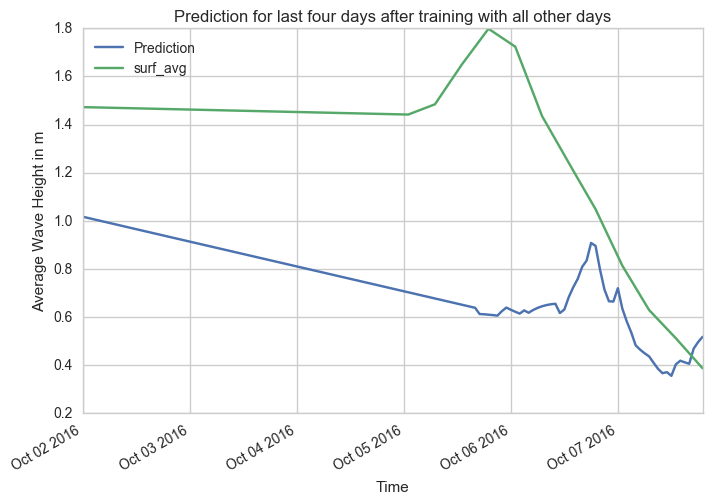

In [21]:
df_train = pd.concat(
    [
        preprocess(df_imported, ma=True, drop_unused=True),
        s_target
    ],
    axis=1
).dropna()

train_set, test_set = split_dataset_last_days(df_train, 5)
model = train_linear_model(train_set)
plot_datetime_series(
    [
        predict(test_set, model),
        test_set[target_var]
    ],
    title= 'Prediction for last four days after training with all other days'
)

### 4.7.4 Final Model

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,ignore_na=False,span=12,min_periods=0).mean()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     805.4
Date:                Mon, 10 Oct 2016   Prob (F-statistic):          6.76e-287
Time:                        15:20:10   Log-Likelihood:                -4542.7
No. Observations:                3392   AIC:                             9089.
Df Residuals:                    3390   BIC:                             9102.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
wave_height          0.1578      0.017      9.362      0.000         0.125     0.191
wind_coefficient     0.6645      0.017     39.090      0.000         0.631     0.698
==============================================================================
Omnibus:                      171.081   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.674
Skew:                           0.563   Prob(JB):                     1.19e-43
Kurtosis:                       3.362   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

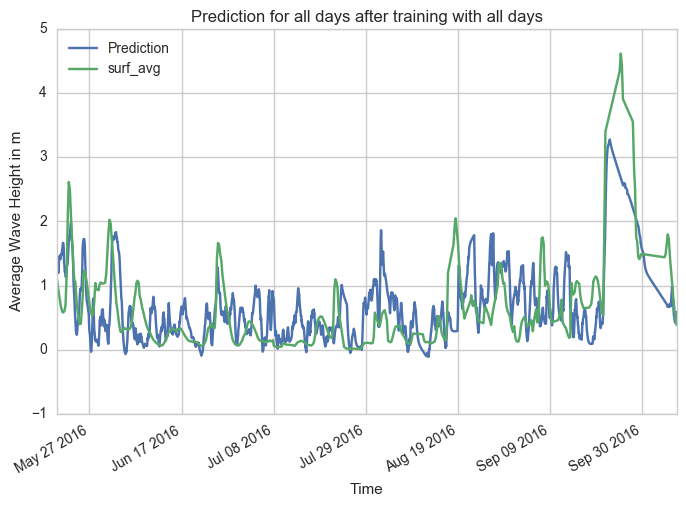

In [22]:
train_set, target = align_data(
    preprocess(df_imported, ma=True, drop_unused=True),
    s_target
)
final_model = train_linear_model(train_set, target)
plot_datetime_series(
    [
        predict(train_set, final_model),
        target
    ],
    title= 'Prediction for all days after training with all days'
)

#### Final Model without Moving Averages

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     670.6
Date:                Mon, 10 Oct 2016   Prob (F-statistic):          4.17e-246
Time:                        15:20:16   Log-Likelihood:                -4636.7
No. Observations:                3392   AIC:                             9277.
Df Residuals:                    3390   BIC:                             9290.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
wave_height          0.1406      0.016      8.624      0.000         0.109     0.173
wind_coefficient     0.5793      0.016     35.525      0.000         0.547     0.611
==============================================================================
Omnibus:                      222.693   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.572
Skew:                           0.616   Prob(JB):                     1.19e-61
Kurtosis:                       3.682   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

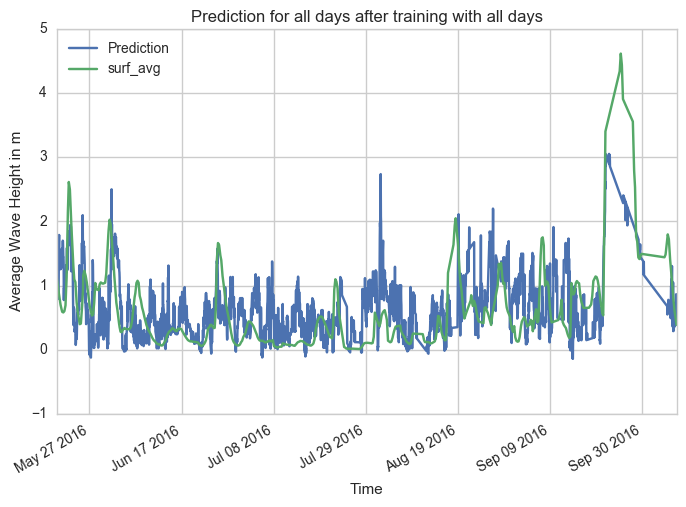

In [23]:
train_set, target = align_data(
    preprocess(df_imported, ma=False, drop_unused=True),
    s_target
)
final_model = train_linear_model(train_set, target)
plot_datetime_series(
    [
        predict(train_set, final_model),
        target
    ],
    title= 'Prediction for all days after training with all days'
)

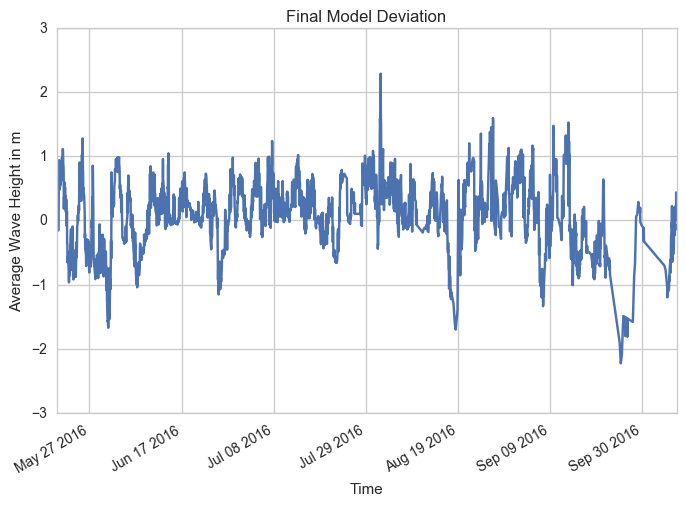

In [24]:
plot_datetime_series(
    [
        predict(train_set, final_model) - target
    ],
    title= 'Final Model Deviation'
)